## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [43]:
# import libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

1a

In [2]:
# read in data set an create data frame
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


1b

In [3]:
# number of rows in dataset
df.shape

(294478, 5)

1c

In [4]:
# number of unique users in dataset
df['user_id'].nunique()

290584

1d

In [5]:
# proportion of users converted
df['converted'].mean()

0.11965919355605512

1e

In [6]:
# number of not matches of new_page and treatment and old_page and control
df.query('group == "control" & landing_page == "new_page" or group == "treatment" & landing_page == "old_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

1f

In [7]:
# assess for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


2a

In [8]:
# delete rows where control and old_page and treatment and new_page do not match
df2 = df.query('group == "control" & landing_page == "old_page" or group == "treatment" & landing_page == "new_page"')

2b

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3a

In [10]:
# number of unique users in df2
df2['user_id'].nunique()

290584

3b

In [11]:
# create filter for duplicated user
fil = df2['user_id'].duplicated()
df2[fil]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


3c

In [12]:
# display duplicated rows
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


3d

In [13]:
# remove duplication
df2.drop([1899], axis=0, inplace=True)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
# control success
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


4a

In [15]:
# probability of converting regardless of received page
df2['converted'].mean()

0.11959708724499628

4b

In [16]:
# create data frame for control group
df_control = df2[df2['group'] == 'control']
df_control.shape

(145274, 5)

In [17]:
# probability of conversion of control group
df_control_convrate = df_control['converted'].mean()
df_control_convrate

0.1203863045004612

4c

In [18]:
# create data frame for treatment group
df_treatment = df2[df2['group'] == 'treatment']
df_treatment.shape

(145310, 5)

In [19]:
# probability of conversion of treatment group
df_treatment_convrate = df_treatment['converted'].mean()
df_treatment_convrate

0.11880806551510564

In [20]:
# calculate observed difference for sample
obs_diff = df_treatment_convrate - df_control_convrate
obs_diff

-0.0015782389853555567

4d

In [21]:
# probability of receiving new page
df2[df2['landing_page'] == 'new_page']['landing_page'].count()/df2['landing_page'].count()

0.5000619442226688

4e

Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**From the above lines I conclude that there is not enough evidence to support the hypothesis that the new page generates more conversions. First, there seems to be a higher conversion rate in the control group in the sample, which also renders the observed difference negativ. This would indicate that within this sample the observed difference falls into the range of the H0.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0: **$p_{new}$**- **$p_{old}$** =< 0

H1: **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
df2.converted.mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
df_treatment.shape[0]

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
df_control.shape[0]

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = df_treatment.sample(df_treatment.shape[0], replace = True)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = df_control.sample(df_control.shape[0], replace = True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
p_new = new_page_converted.converted.mean()
p_new

0.11694308719289795

In [29]:
p_old = old_page_converted.converted.mean()
p_old

0.11993199058331154

In [30]:
obs_diff1 = p_new - p_old
obs_diff1

-0.0029889033904135914

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
p_diffs = []
for _ in range(10000):
    new_page_converted = df_treatment.sample(df_treatment.shape[0], replace = True)
    old_page_converted = df_control.sample(df_control.shape[0], replace = True)
    p_new = new_page_converted.converted.mean()
    p_old = old_page_converted.converted.mean()
    p_diffs.append(p_new - p_old)

In [32]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

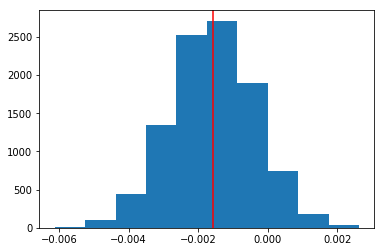

In [33]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
(p_diffs > obs_diff).mean()

0.5045

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [44]:
df_treatment_conv = df_treatment[df_treatment['converted'] == 1]
df_control_conv = df_control[df_control['converted'] == 1]

In [45]:
convert_old = df_control_conv.shape[0]
convert_new = df_treatment_conv.shape[0]
n_old = df_control.shape[0]
n_new = df_treatment.shape[0]
value = 0
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [46]:
stats, pval = sm.stats.proportions_ztest(count, nobs, value)
stats, pval

(1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [47]:
df2['intercept'] = 1
df2[['x', 'ab_page']] = pd.get_dummies(df['group'])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [49]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:29:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [53]:
df_country = pd.read_csv('countries.csv')
df_country.head()

FileNotFoundError: File b'countries.csv' does not exist

In [ ]:
df_country.country.unique()

In [ ]:
df_country.shape

In [ ]:
df2_sorted = df2.sort_values(by=['user_id'])
df2_sorted.head()

In [ ]:
df2_sort_idx = df2_sorted.reset_index()
df2_sort_idx.head()

In [ ]:
df2_sort_idx.drop('index', axis=1, inplace=True)
df2_sort_idx.head()

In [ ]:
df_country_sorted = df_country.sort_values(by=['user_id'])
df_country_sorted.head()

In [ ]:
df_count_idx = df_country_sorted.reset_index()
df_count_idx.head()

In [ ]:
df_count_idx.drop(['index', 'user_id'], axis=1, inplace=True)
df_count_idx.head()

In [ ]:
df_merged = pd.concat([df2_sort_idx, df_count_idx], axis=1)
df_merged.head()

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])